# Christsmas movies - Adventskalendar

This tutorial is the grand finale of our advent calendar, and we're wrapping things up by using a [Kaggle dataset](https://www.kaggle.com/datasets/jonbown/christmas-movies) packed with over 700 fantastic Christmas movies.

We're going to explore how to build a recommendation system. Whether you're a movie buff looking for new holiday favorites or a coding enthusiast eager to try something fun, this tutorial is here to help you out.

We'll walk through the steps together, learning how to transform your data, store it , and create a simple interface. By the end, you'll have the skills to make your own awesome holiday movie search engine and save some time to everyone looking for that perfect movie night.


## Data cleaning

To kick things off, our initial step involves data loading and cleaning. Before we start, you will need to download the dataset from Kaggle's and save the CSV in the same folder as the notebook with this name _Cristmas_movies.csv_. 

We'll start by importing the Pandas library to work with our dataset.

Upon loading the data, our primary focus is to filter out all entries except movies. This helps narrow down our dataset to specifically work with Christmas films.

In [1]:
import pandas as pd

df =  pd.read_csv("christmas_movies.csv")
df = df[df.type == "Movie"].copy()
df.head()

,title,rating,runtime,imdb_rating,meta_score,genre,release_year,description,director,stars,votes,gross,img_src,type
0,Love Actually,R,135.0,7.6,55.0,"Comedy, Drama, Romance",2003.0,Follows the lives of eight very different coup...,Richard Curtis,"Hugh Grant, Martine McCutcheon, Liam Neeson, L...","491,920",$59.70M,https://m.media-amazon.com/images/M/MV5BMTY4Nj...,Movie
1,National Lampoon's Christmas Vacation,PG-13,97.0,7.5,49.0,Comedy,1989.0,The Griswold family's plans for a big family C...,Jeremiah S. Chechik,"Chevy Chase, Beverly D'Angelo, Juliette Lewis,...","198,428",$71.32M,https://m.media-amazon.com/images/M/MV5BMGZkMW...,Movie
2,Spirited,PG-13,127.0,6.6,55.0,"Comedy, Family, Musical",2022.0,A musical version of Charles Dickens's story o...,Sean Anders,"Will Ferrell, Ryan Reynolds, Octavia Spencer, ...","34,304",NaN,https://m.media-amazon.com/images/M/MV5BY2RlZG...,Movie
3,Home Alone,PG,103.0,7.7,63.0,"Comedy, Family",1990.0,"An eight-year-old troublemaker, mistakenly lef...",Chris Columbus,"Macaulay Culkin, Joe Pesci, Daniel Stern, John...","584,210",$285.76M,https://m.media-amazon.com/images/M/MV5BMzFkM2...,Movie
4,How the Grinch Stole Christmas,PG,104.0,6.3,46.0,"Comedy, Family, Fantasy",2000.0,"On the outskirts of Whoville lives a green, re...",Ron Howard,"Jim Carrey, Taylor Momsen, Kelley, Jeffrey Tam...","259,796",$260.04M,https://m.media-amazon.com/images/M/MV5BNWNiNT...,Movie


Upon closer inspection of the movie descriptions, we notice the need for some data cleaning. We'll engage in refining these descriptions by addressing inconsistencies and ensuring uniformity throughout the dataset.

Furthermore, we exclude films without a listed rating. Selecting only the most relevant columns we create a consolidated feature set. 

The title, description, genre, director, and stars will serve as the foundational elements for comparing films and crafting recommendations. So we combine them into one column

In [2]:
df = df[df.description != "Add a Plot"].copy()
df["description"] = df.description.str.split("...   ", n =1).str[0]
df = df[~df.imdb_rating.isna()].copy()
df = df[["title",
         "imdb_rating", 
         "genre", 
         "release_year", 
         "description", 
         "director", 
         "stars", 
         "img_src"]].dropna().reset_index(drop = True).copy()

df["combined"] = df.title + ". " + df.description + ". " + df.genre + ". "+ df.director + ". " + df.stars
df["id"] = [f"{i}A" for i in range(df.shape[0])]

df.head()

,title,imdb_rating,genre,release_year,description,director,stars,img_src,combined,id
0,Love Actually,7.6,"Comedy, Drama, Romance",2003.0,Follows the lives of eight very different coup...,Richard Curtis,"Hugh Grant, Martine McCutcheon, Liam Neeson, L...",https://m.media-amazon.com/images/M/MV5BMTY4Nj...,Love Actually. Follows the lives of eight very...,0A
1,National Lampoon's Christmas Vacation,7.5,Comedy,1989.0,The Griswold family's plans for a big family C...,Jeremiah S. Chechik,"Chevy Chase, Beverly D'Angelo, Juliette Lewis,...",https://m.media-amazon.com/images/M/MV5BMGZkMW...,National Lampoon's Christmas Vacation. The Gri...,1A
2,Spirited,6.6,"Comedy, Family, Musical",2022.0,A musical version of Charles Dickens's story o...,Sean Anders,"Will Ferrell, Ryan Reynolds, Octavia Spencer, ...",https://m.media-amazon.com/images/M/MV5BY2RlZG...,Spirited. A musical version of Charles Dickens...,2A
3,Home Alone,7.7,"Comedy, Family",1990.0,"An eight-year-old troublemaker, mistakenly lef...",Chris Columbus,"Macaulay Culkin, Joe Pesci, Daniel Stern, John...",https://m.media-amazon.com/images/M/MV5BMzFkM2...,"Home Alone. An eight-year-old troublemaker, mi...",3A
4,How the Grinch Stole Christmas,6.3,"Comedy, Family, Fantasy",2000.0,"On the outskirts of Whoville lives a green, re...",Ron Howard,"Jim Carrey, Taylor Momsen, Kelley, Jeffrey Tam...",https://m.media-amazon.com/images/M/MV5BNWNiNT...,How the Grinch Stole Christmas. On the outskir...,4A


## Embeddings

Now, let's dive into the exciting part! We've laid the groundwork by selecting specific features like title or description for movie comparisons. But how does this comparison process unfold?

Computers operate in a world of numbers, and to enable them to understand and process textual data, we need to convert words into numerical representations. However, it's not just about converting words into numbers randomly; we aim to transform them in a manner that ensures related words or concepts are closer together in a mathematical space. And this is what embeddings are.

Embeddings are the secret sauce that allows us to map words or phrases into a multi-dimensional space where their relationships and similarities are preserved. This smart transformation enables us to represent textual information in a numerical format while maintaining the contextual closeness of related words. Essentially, embeddings encode the semantic meaning and relationships between words or phrases, allowing algorithms to analyze and compare them intelligently.

Think of embeddings as a language for computers to understand textual data in a way that captures nuances, contexts, and similarities between words. This mathematical representation forms the backbone of how we'll compare movie features, making our recommendation engine a clever matchmaker for festive films.

In our case, to get embeddings for each film, we can leverage the OpenAI API. This API provides a powerful mechanism to generate embeddings for text data.

We'll begin by importing the necessary libraries and setting up the OpenAI API by inputting our unique API Key. Using the `client.embeddings.create` function, we can then create embeddings for our movie dataset. To achieve this, we'll employ a lambda function, which allows us to seamlessly apply the embedding generation procedure to each entry within our dataset.

In [4]:
import openai

API_KEY = input("Input API KEY:")
client = openai.OpenAI(api_key = API_KEY)

def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

# Get embeddings

df['combined_embedding'] = df.combined.apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))

In [5]:
df.head()

,title,imdb_rating,genre,release_year,description,director,stars,img_src,combined,id,combined_len,combined_embedding
0,Love Actually,7.6,"Comedy, Drama, Romance",2003.0,Follows the lives of eight very different coup...,Richard Curtis,"Hugh Grant, Martine McCutcheon, Liam Neeson, L...",https://m.media-amazon.com/images/M/MV5BMTY4Nj...,Love Actually. Follows the lives of eight very...,0A,304,"[-0.026245662942528725, -0.033299341797828674,..."
1,National Lampoon's Christmas Vacation,7.5,Comedy,1989.0,The Griswold family's plans for a big family C...,Jeremiah S. Chechik,"Chevy Chase, Beverly D'Angelo, Juliette Lewis,...",https://m.media-amazon.com/images/M/MV5BMGZkMW...,National Lampoon's Christmas Vacation. The Gri...,1A,225,"[0.0005187288043089211, -0.025962714105844498,..."
2,Spirited,6.6,"Comedy, Family, Musical",2022.0,A musical version of Charles Dickens's story o...,Sean Anders,"Will Ferrell, Ryan Reynolds, Octavia Spencer, ...",https://m.media-amazon.com/images/M/MV5BY2RlZG...,Spirited. A musical version of Charles Dickens...,2A,214,"[-0.018777716904878616, -0.036875464022159576,..."
3,Home Alone,7.7,"Comedy, Family",1990.0,"An eight-year-old troublemaker, mistakenly lef...",Chris Columbus,"Macaulay Culkin, Joe Pesci, Daniel Stern, John...",https://m.media-amazon.com/images/M/MV5BMzFkM2...,"Home Alone. An eight-year-old troublemaker, mi...",3A,225,"[-0.00331965833902359, -0.037888702005147934, ..."
4,How the Grinch Stole Christmas,6.3,"Comedy, Family, Fantasy",2000.0,"On the outskirts of Whoville lives a green, re...",Ron Howard,"Jim Carrey, Taylor Momsen, Kelley, Jeffrey Tam...",https://m.media-amazon.com/images/M/MV5BNWNiNT...,How the Grinch Stole Christmas. On the outskir...,4A,253,"[0.002101234160363674, -0.03297177702188492, 0..."


In [6]:
len(df.combined_embedding[0])

1536

This means that for every movie in our dataset, we have extracted embeddings using the OpenAI API, effectively transforming the textual information into numerical representations. 

### 2D Compression and Visualization

Our embeddings, while rich in information, have a high number of dimensions —1536, to be precise. In such high dimensions space we can not visualize our data. Hence, we'll compress these multi-dimensional vectors down to a more manageable 2D space for visualization purposes.

To achieve this, we'll employ the TSNE algorithm. This is a powerful technique commonly used to reduce high-dimensional data into lower dimensions while preserving the inherent structure and relationships between data points as much as possible. This process will allow us to visualize the relationships and similarities between different movies in a more intuitive and understandable manner.

In this visualization, similar movies have similar embeddings and tend to cluster together. We can better understand how our recommendation system perceives the relationships between different Christmas films based on their textual features.

Text(0.5, 1.0, 'Imbd ratings visualized in language using t-SNE')

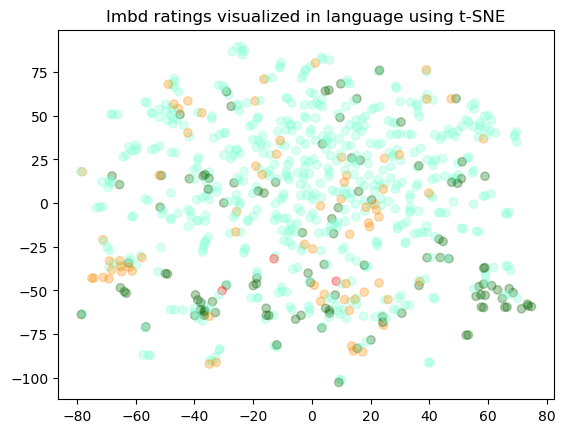

In [7]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matrix = np.array(df.combined_embedding.to_list())

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=10, random_state=42, n_iter = 2000, method= "exact")
vis_dims = tsne.fit_transform(matrix)

df["combined_x"] = [x for x,y in vis_dims]
df["combined_y"] = [y for x,y in vis_dims]

color_indices = (df.imdb_rating / 2).round()

colors = ["red", "darkorange", "gold", "aquamarine", "darkgreen"]
colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(df.combined_x, df.combined_y, c=color_indices, cmap=colormap, alpha=0.3)
plt.title("Imbd ratings visualized in language using t-SNE")

## Pinecone

Wrapping up our journey towards building a powerful movie recommendation system, we'll now delve into the setup of our vector database. Before we proceed, it's important to create an Pinecone account that grants access to the free trial version, providing us with the necessary API key and environment settings.

### Setting up the index

Once we've obtained our credentials, we'll begin by importing the Pinecone library, a versatile tool that enables the management and utilization of vector databases. Using our data, we'll input the movie embeddings we generated earlier into the Pinecone vector database.

In [10]:
import pinecone

pinecone.init(api_key= input(), environment="gcp-starter")

pinecone.create_index("movies", 
                      dimension=len(df.combined_embedding[0]), 
                      metric="cosine")
pinecone.describe_index("movies")

c:\Users\juan\miniconda3\envs\NLP\Lib\site-packages\pinecone\index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


IndexDescription(name='movies', metric='cosine', replicas=1, dimension=1536.0, shards=1, pods=1, pod_type='starter', status={'ready': True, 'state': 'Ready'}, metadata_config=None, source_collection='')

The initial step involves creating our first index within the database. Here, we'll define the index's name, dimensionality (reflecting the number of dimensions in our embeddings), and the metric used for similarity calculation—we'll opt for cosine similarity in this case, a common metric for measuring similarity between vectors. You can also use 'euclidean' or 'dotproduct'.

With our index created, the next step is to initialize it, setting the stage for data insertion. We'll proceed to populate the index in batches using the .upsert method, effectively adding our movie embeddings to the database.

In [16]:
df_transfer  = df.reset_index().rename(columns = {"combined_embedding":"values"})

index = pinecone.Index("movies")

batches = [range(0,200),
           range(200,400),
           range(400,600),
           range(600,741),
           ]

for batch in batches:
  transfer_dict = df_transfer[["id","values"]].iloc[batch].to_dict(orient='records')

  index.upsert(
    vectors= transfer_dict
  )

This process establishes a foundational structure within our vector database, enabling efficient storage and retrieval of movie embeddings. This database will serve as the backbone of our recommendation system, facilitating quick and accurate searches based on similarities between movies.

### Search

We can now query our data. For that we have to create a prompt and  get its embeddings. Then we use the index.query passing the embeddings vector.

In [17]:
prompt = "wants to ruin chritsmas"

search = get_embedding(text = prompt)

results = index.query(
          vector=search,
          top_k=10,
          include_values=True
)

The result is the top 10 closest films to our promp with a similarity score

In [18]:
ids = []
scores = []

for result in results["matches"]:
    ids.append(result["id"])
    scores.append(result["score"])

results_dict = {"id": ids,
                "score": scores}

df_results = pd.DataFrame(results_dict)

pd.set_option('display.max_colwidth', None)
df_results.merge(df[["id", "title", "description"]], on= "id")

,id,score,title,description
0,712A,0.810571,Christmas with Cookie,In the year 3978 global warming has made a desert of the North Pole. Santa and Mrs. Claus battle angry skeletons who didn't get what they wanted for Christmas. Evil aliens try to take over the world and a giant abominable snow man wants Santa for his next meal.
1,229A,0.809400,How to Ruin Christmas,Prodigal daughter Tumi goes home for the holidays and manages to ruin her sister's wedding plans. Now she must make things right before it's too late.
2,633A,0.804614,Christmas with a Capital C,An attorney returns to his small home town in Alaska and quickly rocks the boat by getting an injunction against the nativity display tradition and attacking Christmas.
3,642A,0.804159,All I Want Is Christmas,"A Christmas obsessed Jewish boy on his way to sunny Florida figures out how to get the Christmas of his dreams by trading airline tickets and places with another boy on his way to snowy Christmastown, WA."
4,658A,0.802400,Christmas Is Here Again,"When the evil Krad steals Santa's toy bag he crushes the holiday spirit- and the world's children forget about Christmas. Now, an orphan and her friends embark on a polar adventure to try to stop Krad from destroying Christmas."
5,9A,0.802362,The Grinch,A grumpy Grinch plots to ruin Christmas for the village of Whoville.
6,674A,0.801660,Cancel Christmas,Santa Claus discovers that children have become too greedy and must prove otherwise before his favorite holiday is canceled. His mission is to teach two incorrigible children the importance of charity.
7,359A,0.801154,A Wish For Christmas,"Sara Thomas is the type of woman who prefers to sit on the sidelines at work, but when her big idea for a Christmas initiative is stolen, she makes a wish to Santa that she'll finally have"
8,630A,0.800612,Christmas All Over Again,"A mischievous, swag-obsessed boy must overcome his inner Scrooge, or remain caught in a cycle where everyday is a Christmas without presents."
9,303A,0.799916,The Christmas Star,A counterfeiter finds the true meaning of the holidays.


## Preparing all for our Power App

### Download pictures for galerie

Now, let's tap into the visual aspect of our movie recommendation app. Within our dataset, we have access to links pointing to the covers of these festive films. We'll leverage this information by saving these cover images to a designated folder in SharePoint, a cloud-based collaboration platform.

By organizing and storing these cover images in SharePoint, we're setting the stage for an aesthetically pleasing user interface for our app. This step ensures that the visual representations of these Christmas movies will be readily available for display within our application.

In [19]:
import requests
import shutil

In [20]:
responses = []
root_path = "pictures"  # change to your sharepoint folder url
path = []


for i in range(df.shape[0]):

    url = df.iloc[i,7]
    filename = root_path + f"/{i}.jpg"
    path.append(filename)

    response = requests.get(url, stream=True)
    responses.append(response.status_code)

    if response.status_code == 200:
        with open(filename, 'wb') as file:
            response.raw.decode_content = True
            shutil.copyfileobj(response.raw, file)
        print(f"Image downloaded as {filename}")
    else:
        print("Failed to download the image")

df["path"] = path

Image downloaded as pictures/0.jpg
Image downloaded as pictures/1.jpg
Image downloaded as pictures/2.jpg
Image downloaded as pictures/3.jpg
Image downloaded as pictures/4.jpg
Image downloaded as pictures/5.jpg
Image downloaded as pictures/6.jpg
Image downloaded as pictures/7.jpg
Image downloaded as pictures/8.jpg
Image downloaded as pictures/9.jpg
Image downloaded as pictures/10.jpg
Image downloaded as pictures/11.jpg
Image downloaded as pictures/12.jpg
Image downloaded as pictures/13.jpg
Image downloaded as pictures/14.jpg
Image downloaded as pictures/15.jpg
Image downloaded as pictures/16.jpg
Image downloaded as pictures/17.jpg
Image downloaded as pictures/18.jpg
Image downloaded as pictures/19.jpg
Image downloaded as pictures/20.jpg
Image downloaded as pictures/21.jpg
Image downloaded as pictures/22.jpg
Image downloaded as pictures/23.jpg
Image downloaded as pictures/24.jpg
Image downloaded as pictures/25.jpg
Image downloaded as pictures/26.jpg
Image downloaded as pictures/27.jpg
Im

### Sharepoint list 

Additionally, we'll prepare a CSV file containing relevant details, such as movie titles and their corresponding SharePoint links to the cover images. This CSV file will serve as the foundation to create a SharePoint list—a crucial component that will power our app's functionality.

The SharePoint list acts as a centralized repository housing the movie information, including the URLs to their cover images. This list will seamlessly integrate with our app, enabling smooth access to movie details and associated visuals.

With these foundational elements in place, our app will be equipped not only with comprehensive movie data but also with engaging visual representations, enriching the user experience and enhancing the overall appeal of our Christmas movie recommendation platform.

In [21]:
df_apps = df[["id",
            "title", 
            "imdb_rating", 
            "genre",
            "description", 
            "release_year",
            "director",
            "stars",
            "combined_embedding",
            "path"
            ]].copy()

df_apps["truncated_embedding"] = df_apps["combined_embedding"].str[:10]

In [22]:
df_apps[["id",
        "title", 
        "imdb_rating", 
        "genre",
        "description", 
        "release_year",
        "director",
        "stars",
        "truncated_embedding",
        "path"
        ]
    ].to_csv("ds_for_powerapps.csv")

df_transfer  = df_apps.reset_index().rename(columns = {"combined_embedding":"values"})